In [1]:
# import packages
from math import sqrt,ceil,floor
import math
# import trackpy as tp
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from scipy import interpolate
plt.rc('text', usetex=True)
from numba import jit,prange
# import numba
from scipy.stats import gaussian_kde,norm
from scipy.interpolate import splev, splrep
from scipy.optimize import curve_fit
import time
import datetime
import os
import glob
from tqdm import tqdm
import itertools

# for list slicing.
from operator import itemgetter

import cv2 #package for image analysis
from scipy import spatial # for KD tree


plt.rcParams['font.size']=20
plt.rcParams["font.family"] = "Times New Roman"


# plt.rcParams["mathtext.fontset"] = font2


from IPython.display import Latex
from IPython.display import Markdown

In [2]:
# subFolder='Simul_20190212_dblLineAsym2'
# subFolder='Simul_20190212_dblLineAsym2_drag2'
# subFolder='Simul_n4_20190114_S25_dilute_WrongPassiveVoltage' # ran with the 20190214_dblLineAsym\DEP20X1p5X_S25_2TMA_0H2O2_0p64pp_flippedDevice_007_EnergyForceProfiles.csv
# subFolder='CheckPressureTheoryNewFunctionExpt' # ran with the 20190214_dblLineAsym\DEP20X1p5X_S25_2TMA_0H2O2_0p64pp_flippedDevice_007_EnergyForceProfiles.csv

# subFolder='ExtremeAsymBiharmonic' 
# subFolder='ThermalLimitBiHarmonic'
# subFolder='ThermalLimitBiHarmonicSym2'

# subFolder='ExtremeAsymHarmonicAgain2'

subFolder='20190926_HMDS_AF_tau_SDS_Relay/Drag2' # agrees with theory P, as long as low persistence length compared to bulk
subFolder='20190926_HMDS_AF_tau_SDS_Relay/FitDrag' # agrees with theory P, as long as low persistence length compared to bulk
subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\FitDrag_movie'
subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScan'

# subFolder='20190212_dblLineAsym2/With008CalibDragMult2' # agrees with theory P, as long as low persistence length compared to bulk


CurrentFolder=os.getcwd()
CurrentFolder=CurrentFolder.replace('\\',r'/')+'/'+subFolder

In [3]:
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\\OrderParamScan'

In [4]:
print(CurrentFolder)
filelistMeta=glob.glob(CurrentFolder+'/*MetaData.csv')
filelistPDF=glob.glob(CurrentFolder+'/*PDfunc.csv')
DataSummary=pd.DataFrame()
for filename in filelistMeta:
    DataSummary=DataSummary.append(pd.read_csv(filename,index_col=False))
DataSummary['tau_s'] = 1/DataSummary['D_R_Ps']
DataSummary['Force_Norm'] = DataSummary['AverageForceLeft_N']/DataSummary['tau_s']/DataSummary['ProbAtCenter']
print('Voltages:', np.sort(pd.unique(DataSummary['ActiveVoltage'])))
print('Velocities:',np.sort(pd.unique(DataSummary['velocity_umPs'])))
print('D_R:',np.sort(pd.unique(DataSummary['D_R_Ps'])))
print('Number Of particles:',np.sort(pd.unique(DataSummary['NumberOfParticles'])))
print('Drag multipliers', np.sort(pd.unique(DataSummary['drag_multiplier'])))
print('Torque ratio C', np.sort(pd.unique(DataSummary['C_ratio_dlctrc_cnst'])))

C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\OrderParamScan
Voltages: [8]
Velocities: [0.2  0.5  0.75 1.   1.25 1.5  1.75 2.  ]
D_R: [0.006      0.00625    0.00666667 0.007      0.0075     0.008
 0.01       0.015      0.0175     0.02       0.025      0.03
 0.035      0.0375     0.04       0.05       0.0625     0.06666667
 0.075      0.0875     0.1        0.125      0.15       0.16666667
 0.175      0.2        0.25       0.3        0.33333333 0.35
 0.4        0.41666667 0.5        0.58333333 0.66666667]
Number Of particles: [100]
Drag multipliers [1.82]
Torque ratio C [1]


## Plots: general

In [5]:
# ADd feature to sum pressure only on last frames, using coords. 
PlotVariables=['ActiveVoltage', 'velocity_umPs', 'D_R_Ps', 'NumberOfParticles', 'C_ratio_dlctrc_cnst', 'drag_multiplier']
VariableStrings=['$V$ [V]', '$v$ [$\mu$m/$s$]','D_{\mathrm{R}}', '\# particles', 'C ratio','drag_multiplier']
indsToConstantVariables=  (0,4,5,   3,  2); 
ValuesOfConstantVariables=[8,1,1.82,100,1/50]

MaximalVelocity = 10
ChosenVelocities=[1, 1.6, 1.9]
PlotTheory=True
ForceProbCenter=True
UseChosenVelocitiesOnly = False
XlimForDensityPlot=(-10,110)
ind_to_X_axis=1
ind_to_legend=1 # legend of the density plot. 

Total points after velocity filter 48
48 ActiveVoltage 8
48 C_ratio_dlctrc_cnst 1
48 drag_multiplier 1.82
48 NumberOfParticles 100
3 D_R_Ps 0.02


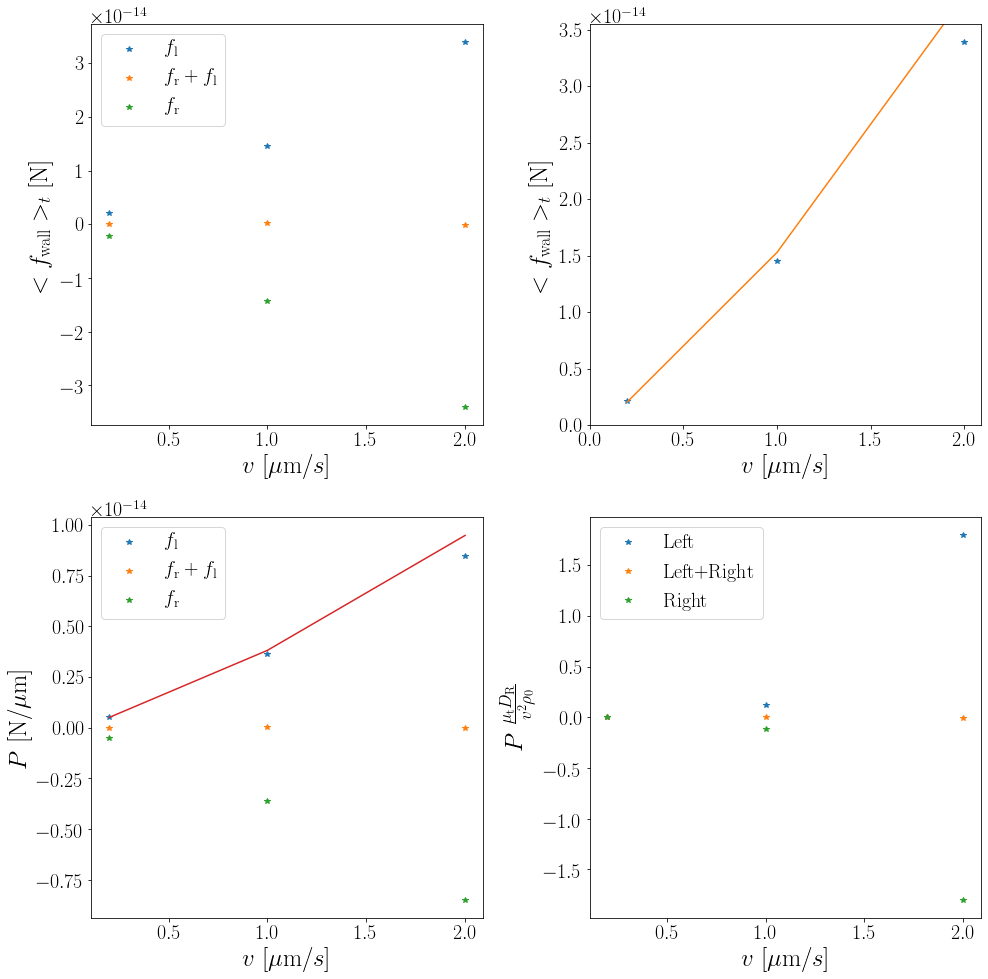

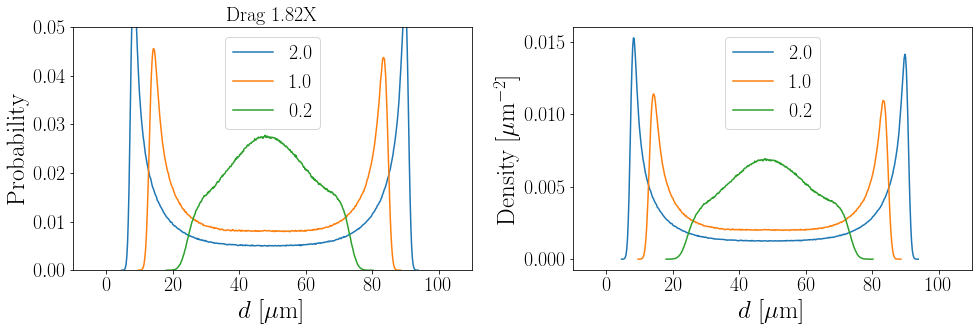

In [6]:
# all plots
if 1: # filter results
    ConstantVariableNames=itemgetter(*indsToConstantVariables)(PlotVariables)
    DFforPlot=DataSummary.copy()
    DFforPlot=DFforPlot.loc[DFforPlot['velocity_umPs']<MaximalVelocity]
    if UseChosenVelocitiesOnly:
        DFforPlot=DFforPlot.loc[DFforPlot['velocity_umPs'].isin(ChosenVelocities)] 
    print('Total points after velocity filter', len(DFforPlot))
    for ConstantVariableName,ValueOfConstantVariable in zip(ConstantVariableNames,ValuesOfConstantVariables):
        if ConstantVariableName in DFforPlot.columns:
            DFforPlot=DFforPlot.loc[np.abs((DFforPlot[ConstantVariableName]-ValueOfConstantVariable))<np.abs(ValueOfConstantVariable/1000)]
            print(len(DFforPlot), ConstantVariableName, ValueOfConstantVariable)
    # sorting by legend index
    DFforPlot=DFforPlot.sort_values(PlotVariables[ind_to_legend], ascending = False)
    # Use arrays for plots
    X_axis=DFforPlot[PlotVariables[ind_to_X_axis]]
    HalfAdd=str()
    if 'AverageForceLeft_N_lastHalf' in DFforPlot.columns:
        HalfAdd='_lastHalf'
    plotLeftForce  = DFforPlot['AverageForceLeft_N'+HalfAdd].values;
    plotRightForce = DFforPlot['AverageForceRight_N'+HalfAdd].values;
    plotSumForce   = DFforPlot['SumAverageForce_N'+HalfAdd].values;
    plotLeftP  = DFforPlot['PressureLeft_NPum'+HalfAdd].values;
    plotRightP = DFforPlot['PressureRight_NPum'+HalfAdd].values;
    plotSumP   = DFforPlot['SumPressure_NPum'+HalfAdd].values;
    mobilities=1/DFforPlot['drag_N_sPum'].values;
    ProbsAtCenter=DFforPlot['ProbAtCenter']
    ForcedDensityAtCneter=list()
    NumberOfParticlesArray=DFforPlot['NumberOfParticles']
    plt.rcParams['font.size']=20
    fig1, ax1=plt.subplots(2,2, figsize=([14,14])) 
if 1: # Plots: 0,0 and 0,1 forces    
    ax1[0,0].plot(X_axis,plotLeftForce, '*')
    ax1[0,0].plot(X_axis,plotSumForce, '*')
    ax1[0,0].plot(X_axis,plotRightForce, '*')
    ax1[0,0].set_ylabel('$<f_{\mathrm{wall}}>_t$ $\mathrm{[N]}$',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[0,0].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[0,0].legend(['$f_{\mathrm{l}}$','$f_{\mathrm{r}}+f_{\mathrm{l}}$','$f_{\mathrm{r}}$'])#, bbox_to_anchor=(0.45, 0.87))
    ax1[0,1].plot(X_axis,plotLeftForce, '*')
    ax1[0,1].set_ylabel('$<f_{\mathrm{wall}}>_t$ $\mathrm{[N]}$',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[0,1].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[0,1].set_xlim(left=0)
    ax1[0,1].set_ylim(bottom=0)
if 1: # Plots: Pressure 
    ax1[1,0].plot(X_axis,plotLeftP, '*')
    ax1[1,0].plot(X_axis,plotSumP, '*')
    ax1[1,0].plot(X_axis,plotRightP, '*')
    ax1[1,0].set_ylabel('$P$ [N/$\mu$m]',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[1,0].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[1,0].legend(['$f_{\mathrm{l}}$','$f_{\mathrm{r}}+f_{\mathrm{l}}$','$f_{\mathrm{r}}$'])
if 1: # Plots: Normalized pressure 
    NormalizingFactor=ProbsAtCenter/mobilities/DFforPlot['D_R_Ps']/DFforPlot['velocity_umPs']**2
    ax1[1,1].plot(X_axis,plotLeftP/NormalizingFactor, '*')
    ax1[1,1].plot(X_axis,plotSumP/NormalizingFactor, '*')
    ax1[1,1].plot(X_axis,plotRightP/NormalizingFactor, '*')
    ax1[1,1].set_ylabel('$P$ $\\frac{\mu_\mathrm{t}D_{\mathrm{R}}}{v^2\\rho_0} $',fontsize=25)
    # plt.title('$V$='+str(ActiveVelForPlot)+'V, $\\tau_\mathrm{Rot}=10$ [s]',fontsize=20)
    ax1[1,1].set_xlabel(VariableStrings[ind_to_X_axis],fontsize=25)
    ax1[1,1].legend(['Left','Left+Right','Right'])
    fig1.tight_layout()
if 1: # Plots: density plots. 
    fig, ax=plt.subplots(1,2, figsize=([14,5]))
    legend=DFforPlot[PlotVariables[ind_to_legend]].values
    for filenameBase,velocity,Voltage,NumberOfParticles in zip(DFforPlot['filenameBase'].values[:],
                                                           DFforPlot['velocity_umPs'].values[:],
                                                           DFforPlot['ActiveVoltage'].values[:],
                                                           DFforPlot['NumberOfParticles'].values):
        filename=CurrentFolder+'/'+filenameBase+('_PDfunc.csv')
        pdf=pd.read_csv(filename)['pdf']
        x_um=pd.read_csv(filename)['x_um']
        ax[0].plot(x_um,pdf)
        # get density using meta file
        metafilename=CurrentFolder+'/'+filenameBase+('_MetaData.csv')
        ChannelLength_um=pd.read_csv(metafilename)['ChannelLength_um'].values[0]
        BoxX_um=pd.read_csv(metafilename, index_col=False)['BoxX_um'].values[0]
        density=pdf*NumberOfParticles/BoxX_um # you can check this expression using np.sum(density*np.diff(x_um).mean()*BoxX), an integration over density
        ax[1].plot(x_um,density)
        ForcedDensityAtCneter.append(density[int(len(density)/2-1)])
    ax[0].set_ylabel('Probability',fontsize=25)
    ax[1].set_ylabel('Density [$\mu$m$^{-2}$]',fontsize=25)
    ax[0].set_xlabel('$d$ [$\mu$m]',fontsize=25)
    ax[1].set_xlabel('$d$ [$\mu$m]',fontsize=25)
    ax[0].legend(legend, loc=0)
    ax[1].legend(legend, loc=0)
    ax[1].set_xlim(XlimForDensityPlot)
    ax[0].set_xlim(XlimForDensityPlot)
    ax[0].set_ylim([0,0.05]);
    ax[0].set_xlim([-10,110]);

    ax[0].set_title('Drag ' + str(DFforPlot['drag_multiplier'].values[0]) + 'X', fontsize = 20)
    fig.tight_layout()
if PlotTheory: # Solon's theory for no-Torque partilces
    # pressure
    DensityAtCenter=ProbsAtCenter*DFforPlot['NumberOfParticles']/DFforPlot['BoxX_um']
    if ForceProbCenter:
        DensityAtCenter=ForcedDensityAtCneter
    TheorP=DFforPlot['velocity_umPs']**2*DFforPlot['drag_N_sPum']/2/DFforPlot['D_R_Ps']*DensityAtCenter
    ax1[1,0].plot(X_axis,TheorP)
    # force per particle
    TheorF=TheorP/NumberOfParticlesArray*DFforPlot['BoxX_um']
    ax1[0,1].plot(X_axis,TheorF)
if 0: # plot force profile, after considering force factor
    ForceProfileFile=glob.glob(CurrentFolder+'/*ForceProfile.csv')[0]
    ForceProfileFile=ForceProfileFile.replace('\\','/')
    x_axis_um=np.loadtxt(ForceProfileFile, delimiter=",")[:,0]
    F_profile_N=np.loadtxt(ForceProfileFile, delimiter=",")[:,1]*DFforPlot['ForceFactor'].mean()
    if DFforPlot['ForceFactor'].std()!=0:
        print('WARNING: files have different force factors. The plotted force profile was caluclated using average. This should not affect the pressure and force values')
    plt.figure(figsize=(7,5))
    plt.plot(x_axis_um, F_profile_N)
    plt.xlabel('$d$ [$\mu$m]',fontsize=25)
    plt.ylabel('$f_{\mathrm{wall}}$ [N]',fontsize=25)
if 0: # Plots: Probability plots. 
    plt.figure(figsize=[10,5])
    legend=DFforPlot[PlotVariables[ind_to_legend]].values
    for filenameBase,velocity,Voltage,NumberOfParticles in zip(DFforPlot['filenameBase'].values[:],
                                                           DFforPlot['velocity_umPs'].values[:],
                                                           DFforPlot['ActiveVoltage'].values[:],
                                                           DFforPlot['NumberOfParticles'].values):
        filename=CurrentFolder+'/'+filenameBase+('_PDfunc.csv')
        pdf=pd.read_csv(filename)['pdf']
        x_um=pd.read_csv(filename)['x_um']
        plt.plot(x_um,pdf)
        # get density using meta file
        metafilename=CurrentFolder+'/'+filenameBase+('_MetaData.csv')
        ChannelLength_um=pd.read_csv(metafilename)['ChannelLength_um'].values[0]
        BoxX_um=pd.read_csv(metafilename, index_col=False)['BoxX_um'].values[0]
        density=pdf*NumberOfParticles/BoxX_um # you can check this expression using np.sum(density*np.diff(x_um).mean()*BoxX), an integration over density
        ForcedDensityAtCneter.append(density[int(len(density)/2-1)])
    plt.ylabel('Probability',fontsize=25)
    plt.xlabel('$d$ [$\mu$m]',fontsize=25)
    plt.xticks(fontsize=25);
    plt.yticks(fontsize=25);
    plt.legend(legend, loc=0)
    plt.xlim([-10,110]);
plt.tight_layout()
# plt.show()

In [7]:
# plt.plot(NumberOfParticlesArray,ProbsAtCenter*NumberOfParticlesArray/BoxX_um, 'o')
# plt.ylabel('Density [$\mu$m$^{-2}$]')
# plt.xlabel('\# particles')

In [8]:
def FitToLinearCurve(x,y,plotFlag=False):
    func = lambda x,*p: p[0]*x+p[1];
    popt, pcov=curve_fit(func, x, y, [1,0])
    y_new = func(x, *popt)
    if plotFlag:
        plt.plot(x, y_new, x, y,'*')
    return popt;

<IPython.core.display.Javascript object>


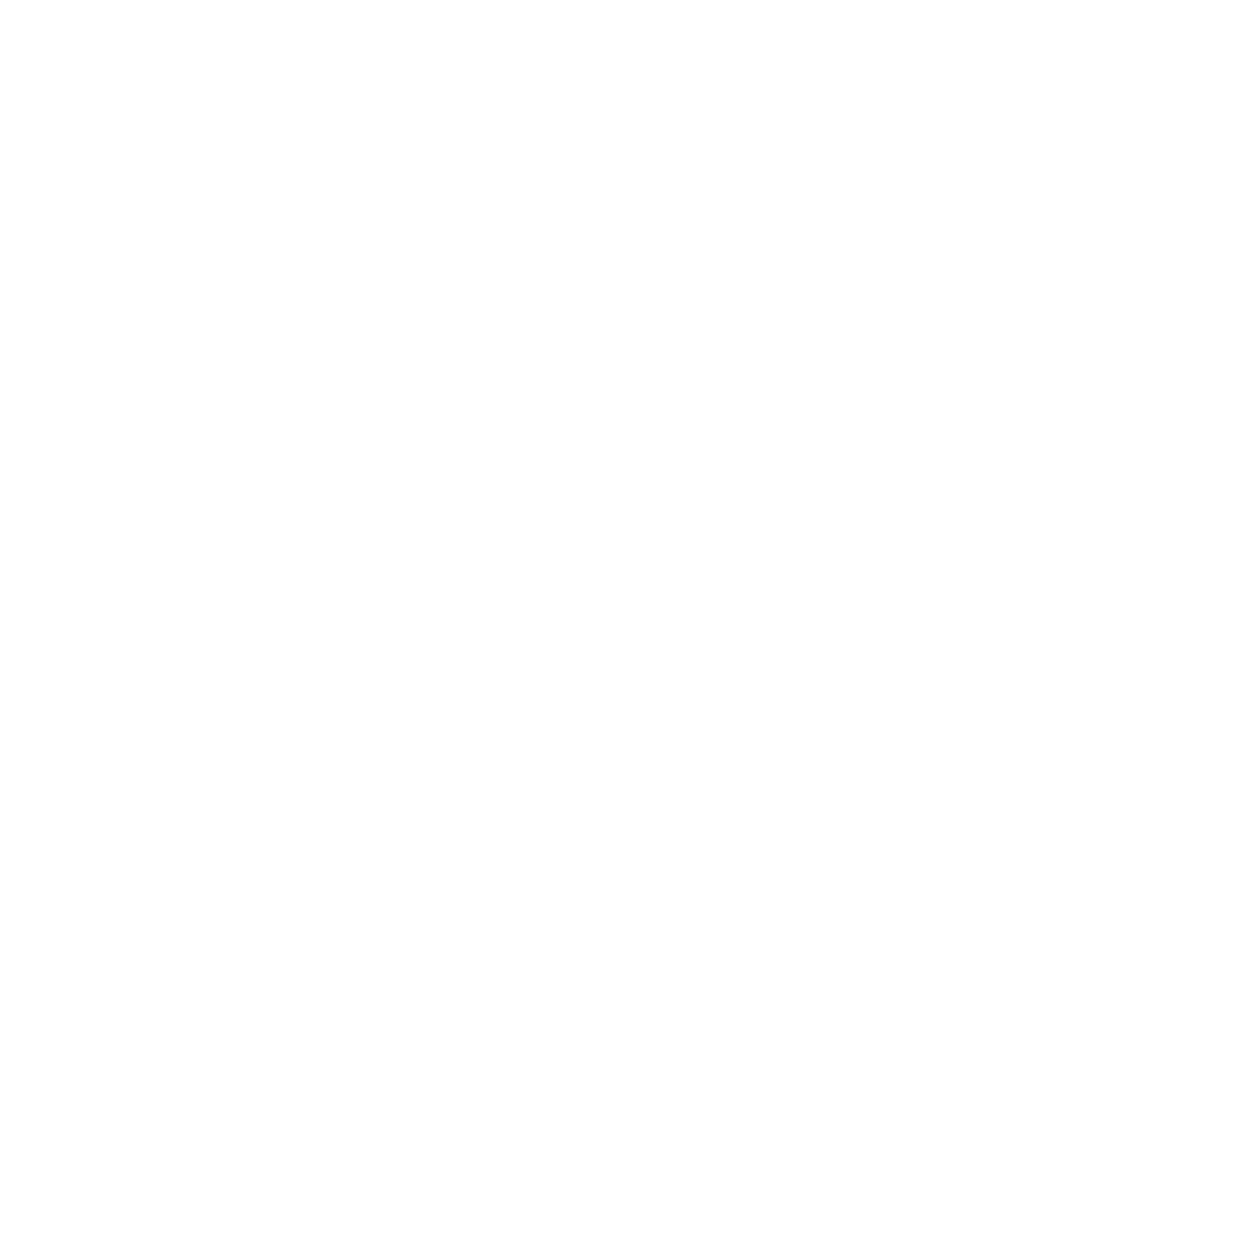

NameError: name 'NormalizedForceSlope' is not defined

In [9]:
# plot grapיs for multiple taus
import itertools
%matplotlib notebook
%matplotlib notebook
fig, ax = plt.subplots(2,2, figsize = (10,10))
colors = itertools.cycle(["r", "b", "g", 'k', 'y', 'm'])
tau_array = np.sort(1/pd.unique(DataSummary['D_R_Ps']))
FitNormalizedForceCurve = False
# tau_array = tau_array[:-1]
AllDFforPlot = pd.DataFrame()
if 1: # plot equilibrium
    kT = 4.11 * 10**(-21)
    ax[0,0].plot(0, 0, 's' ,label = 'Eq.')
    ax[1,0].plot(0, 0, 's' ,label = 'Eq.')
for tau in tau_array:
    color = next(colors)
    DFforPlot = DataSummary.loc[DataSummary['tau_s'] == tau]
    if 1: # 0,0: force vs. v
        label = str(int(DFforPlot['tau_s'].values[0]))
        ax[0,0].plot(DFforPlot['velocity_umPs'], DFforPlot['AverageForceLeft_N'] , '*', label = label, color = color)
        ax[0,0].legend(fontsize = 16)
        ax[0,0].set_ylabel('$f$ [N]')
        ax[0,0].set_xlabel('$v$ [$\mu$m/s]')
        ax[0,0].set_xlim(right = 2)
    if 1: # 1,0: normalized forces
        ax[1,0].plot(DFforPlot['velocity_umPs']**2, DFforPlot['Force_Norm'], '*', label = label, color = color)
        # ax[1,0].plot(0,0,'x')
        ax[1,0].set_ylabel('$f/\\tau/\mathrm{Pr_0}$ [N$\mu$m/s]')
        ax[1,0].set_xlabel('$v^2$ [$\mu$m$^2$/s$^2$]')   
        ax[1,0].set_ylim([0,1.5E-13])         
    if 0: # 1,1: Plot maximal forces
        ax[1,1].plot(DFforPlot['V_mean_um'], DFforPlot['MaximalForce_N'],'o', color = color)
        ax[1,1].set_xlim(right = 2)
        ax[1,1].set_ylabel('$f_{\mathrm{max}}$ [N]')
        ax[1,1].set_xlabel('$v$ [$\mu$m/s]') 
    AllDFforPlot = pd.concat([AllDFforPlot,DFforPlot])
if FitNormalizedForceCurve: # 0,1: fit curve to normalized data
    popt = FitToLinearCurve(AllDFforPlot['velocity_umPs']**2, AllDFforPlot['Force_Norm'], plotFlag=False)
    x = np.linspace(0,AllDFforPlot['velocity_umPs'].max()**2, 40)
    y = popt[0] * x + popt[1]
    NormalizedForceSlope = popt[0]
    ax[1,0].plot(x,y,'k')
if 0: # 1,1: fit curve to maximal force
    x, y = AllDFforPlot['V_mean_um'], AllDFforPlot['MaximalForce_N']
    func = lambda x,p: p*x;
    popt, pcov=curve_fit(func, x, y)
    # popt = FitToLinearCurve(x, y, plotFlag=False)
    x_new = np.linspace(0,SummaryTable['V_mean_um'].max(), 40)
    y_new = func(x_new, *popt)
    MaxForceSlope = popt[0]
    ax[1,1].plot(x_new,y_new,'k')
print('Drag from normalized force profile (2 x slope) is: ', '{:0.1e}'.format(NormalizedForceSlope*2), 'Ns/ \mu m')
# print('Drag from maximal force (slope) is: ', '{:0.1e}'.format(MaxForceSlope), 'Ns/ \mu m')
fig.tight_layout()

In [ ]:
DO NOT FORGET FORCE FACTOR!!!!

In [5]:
%matplotlib notebook
%matplotlib notebook

# See orientations!!!!!!!!!

In [62]:
subFolder='20190926_HMDS_AF_tau_SDS_Relay/FitDrag_movie' # agrees with theory P, as long as low persistence length compared to bulk
CurrentFolder=os.getcwd()
CurrentFolder=CurrentFolder.replace('\\',r'/')+'/'+subFolder
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay/FitDrag_movie'

In [101]:
ShortFilename = r'Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p005_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p1_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'
# ShortFilename = r'Sim_V_8_vel_3p5_Dt_0p1_C_1_Dr_0p005_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'

# ShortFilename = 'Sim_V_10p2_vel_3p6_Dt_0p1_C_1p001_Dr_0p1_NumPrtcls_1_dragFactorToPsv_2_coords.csv'
# ShortFilename = 'Sim_V_10p2_vel_3p6_Dt_0p1_C_1p002_Dr_0p05_NumPrtcls_1_dragFactorToPsv_2_coords.csv'


FullPathTrajFilename = CurrentFolder + '//' + ShortFilename
MetafileShortFilename = ShortFilename.replace('coords', 'MetaData')
FullPathMetaFilename = CurrentFolder + '//' + MetafileShortFilename
LoadedMetaDF = pd.read_csv(FullPathMetaFilename, index_col = False)

# np.loadtxt(FullPathTrajFilename)
# TrajArray = np.genfromtxt(FullPathTrajFilename, delimiter=',')
# TrajArray = np.loadtxt(FullPathTrajFilename, delimiter=',')
TrajArray = pd.read_csv(FullPathTrajFilename, delimiter=',', index_col = False) # because it works fast and does not use RAM
TrajArray = np.array(TrajArray)

In [102]:
FullPathTrajFilename

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay/FitDrag_movie//Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p005_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'

## Orientations using x,y data (to mimic experiments)

In [103]:
VelocityCutOff = 6; 
StartingStep = 200

In [104]:
velDiff = 2
TrajArrayCropStart = TrajArray[StartingStep:]
x = TrajArrayCropStart[:,1]
y = TrajArrayCropStart[:,2]
dx = x[velDiff:] - x[:-velDiff]
dy = y[velDiff:] - y[:-velDiff]
BooleanToUse = (dx**2+dy**2) < velDiff * VelocityCutOff**2
x = TrajArrayCropStart[velDiff:,1][BooleanToUse]
y = TrajArrayCropStart[velDiff:,2][BooleanToUse]
p = TrajArrayCropStart[velDiff:,0][BooleanToUse]
dx = dx[BooleanToUse]/velDiff
dy = dy[BooleanToUse]/velDiff

(-10, 110)

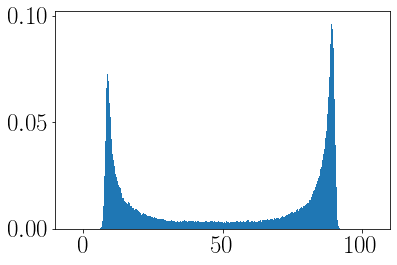

In [105]:
plt.hist(y, bins = 500, density = 'norm');
plt.xlim([-10,110])

In [208]:
%matplotlib inline
%matplotlib inline

Use a Legendre polynomial as order parameter:

In 3D: S = $\left<\frac{3\cos^2 \theta -1}{2}\right>$

In 2D: S = $2\left<\cos^2 \theta -1\right>$ = $\left<\cos 2\theta\right>$

Using x and y for velocity, not the hematite orientation


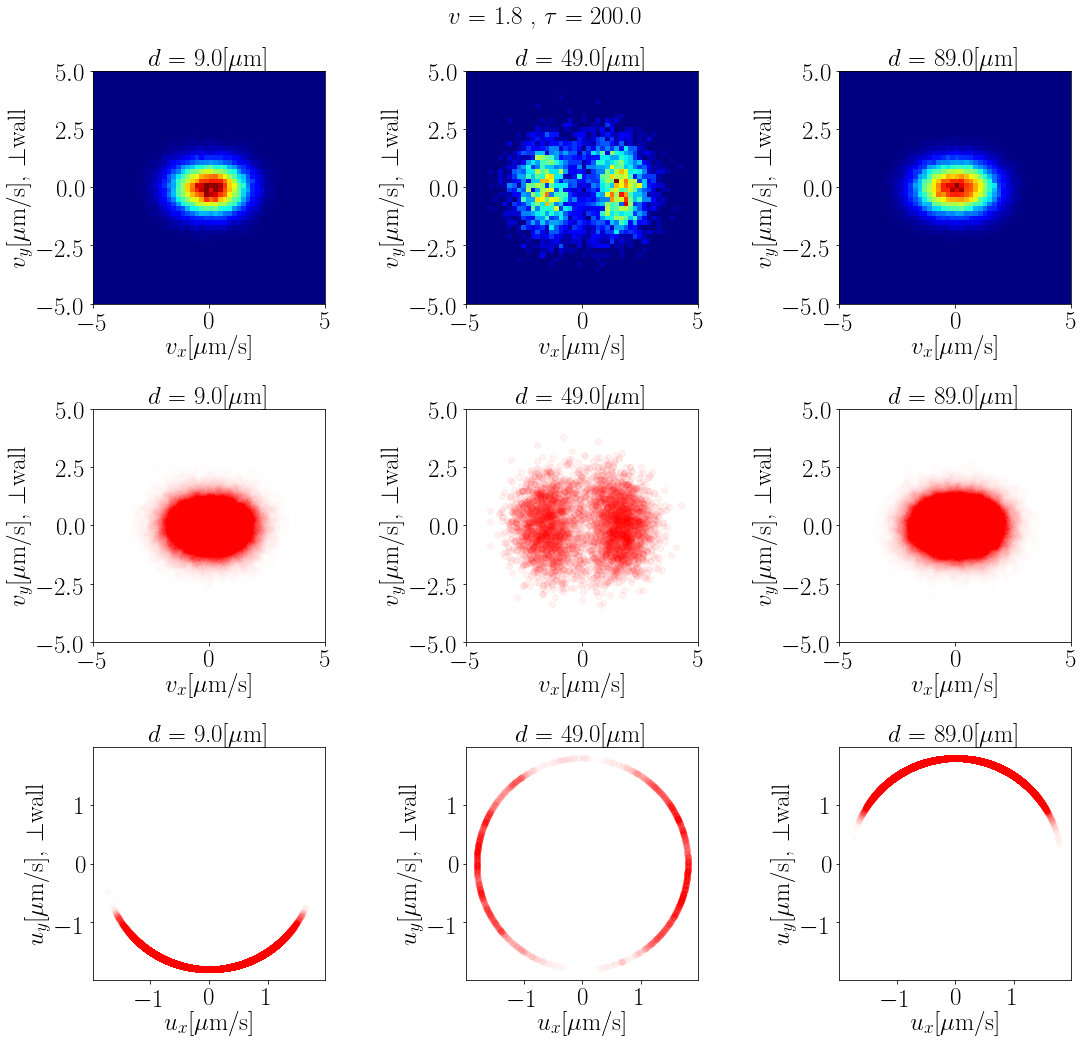

In [108]:
DistancesToSample = [48.8-40, 48.8, 48.8+40] # 51,18,82
ExportFile = False
range_um = 2
fps = 5 # this is the sampling rate in the coordinates file. You need to change it or get it from the meta. 
UseHeatMap = False
LimitVelocityForPlot = 5
print('Using x and y for velocity, not the hematite orientation')
FactorForUmPs = fps
fig, ax = plt.subplots(3, len(DistancesToSample), figsize = [16,15])
for ind, DistanceToSample in enumerate(DistancesToSample):
    MaxDistance = DistanceToSample + range_um/2
    MinDistance = DistanceToSample - range_um/2
    if 1: # first panel displacements scatter
        if ((DistanceToSample<60) & (DistanceToSample>40)):
            alpha = 0.05
        else:
            alpha = 0.002
        ax[0,ind].hist2d(FactorForUmPs*dx[(y>MinDistance) & (y<MaxDistance)], 
                FactorForUmPs*dy[(y>MinDistance) & (y<MaxDistance)], bins = 50, cmap = 'jet', 
                         range = [[-LimitVelocityForPlot, LimitVelocityForPlot], [-LimitVelocityForPlot, LimitVelocityForPlot]], 
                  density = True);
    if 2: # second panel heatmap displacements
        ax[1, ind].scatter(FactorForUmPs*dx[(y>MinDistance) & (y<MaxDistance)], 
                    FactorForUmPs*dy[(y>MinDistance) & (y<MaxDistance)], alpha = alpha, color= 'r')
    # set legends for panels 1, 2
    for panel in list([0,1]):
        ax[panel,ind].set_xlim([-LimitVelocityForPlot,LimitVelocityForPlot])
        ax[panel,ind].set_ylim([-LimitVelocityForPlot,LimitVelocityForPlot])
        ax[panel,ind].set_xlabel('$v_x[\mu$m/s]')
        ax[panel,ind].set_ylabel('$v_y[\mu$m/s], $\\bot$wall')
        ax[panel,ind].set_aspect('equal', adjustable='box')
        ax[panel,ind].set_title('$d$ = ' + str(np.round(DistanceToSample)) + '[$\mu$m]')
    if 3: # third panel with driving swimming direction
        alpha = 0.01
        Swimming_velocity = LoadedMetaDF['velocity_umPs'][0]
        ax[2,ind].scatter(Swimming_velocity*np.cos(p[(y>MinDistance) & (y<MaxDistance)]), 
                        Swimming_velocity*np.sin(p[(y>MinDistance) & (y<MaxDistance)]), alpha = alpha, color= 'r')
        ax[2,ind].set_xlim([-1.1*Swimming_velocity,1.1*Swimming_velocity])
        ax[2,ind].set_ylim([-1.1*Swimming_velocity,1.1*Swimming_velocity])
        ax[2,ind].set_xlabel('$u_x[\mu$m/s]')
        ax[2,ind].set_ylabel('$u_y[\mu$m/s], $\\bot$wall')
        ax[2,ind].set_aspect('equal', adjustable='box')
        ax[2,ind].set_title('$d$ = ' + str(np.round(DistanceToSample)) + '[$\mu$m]')
tau = 1/LoadedMetaDF['D_R_Ps'][0]
fig.suptitle('$v$ = ' + str(Swimming_velocity) + ' , $\\tau$ = ' + str(tau)) 
fig.tight_layout()
fig.subplots_adjust(top=0.92)
if ExportFile:
    exportFilename = FullPathTrajFilename.replace('coords.csv', '.jpg')
    plt.savefig(exportFilename, dpi = 500)

### Order parameter from experiment (order parameter files, not coords)

I could also retrieve this from the trajectories. If I do that, I will actually be able to get the average theta as well. I can also fix the code to calculate things more correctly:

$N\left<\theta_0 \right> = \large{\Sigma} \small{(\theta \% \pi) / 2}$

$N\left<\cos\theta \right> = \large{\Sigma} \small{(\cos\theta \% \pi) / 2}$

$N\left<\sin\theta \right> = \large{\Sigma} \small{(\sin\theta \% \pi) / 2}$


In [128]:
# subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScan'
subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScanNoDiffusion'
# subFolder =r'20190926_HMDS_AF_tau_SDS_Relay\OrderParamScan_highVel'

CurrentFolder=os.getcwd()
CurrentFolder=CurrentFolder.replace('\\',r'/')+'/'+subFolder

In [129]:
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\\OrderParamScanNoDiffusion'

In [130]:
filename

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\\OrderParamScan_highVel\\Sim_V_8_vel_5_Dt_0p1_C_1_Dr_0p5_NumPrtcls_100_dragFactorToPsv_1p82_MetaData.csv'

In [131]:
print(CurrentFolder)
filelistMeta=glob.glob(CurrentFolder+'/*MetaData.csv')
filelistPDF=glob.glob(CurrentFolder+'/*PDfunc.csv')
filelistOrderParam=glob.glob(CurrentFolder+'/*OrderParam.csv')
DataSummary=pd.DataFrame()
for filename in filelistMeta:
    DataSummary=DataSummary.append(pd.read_csv(filename,index_col=False))
DataSummary['tau_s'] = 1/DataSummary['D_R_Ps']
DataSummary['Force_Norm'] = DataSummary['AverageForceLeft_N']/DataSummary['tau_s']/DataSummary['ProbAtCenter']
print('Voltages:', np.sort(pd.unique(DataSummary['ActiveVoltage'])))
print('Velocities:',np.sort(pd.unique(DataSummary['velocity_umPs'])))
print('D_R:',np.sort(pd.unique(DataSummary['D_R_Ps'])))
print('Number Of particles:',np.sort(pd.unique(DataSummary['NumberOfParticles'])))
print('Drag multipliers', np.sort(pd.unique(DataSummary['drag_multiplier'])))
print('Torque ratio C', np.sort(pd.unique(DataSummary['C_ratio_dlctrc_cnst'])))

C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\OrderParamScanNoDiffusion
Voltages: [8]
Velocities: [0.2  0.5  0.75 1.   1.25 1.5  1.75 2.  ]
D_R: [0.005      0.00625    0.0075     0.00875    0.01       0.015
 0.0175     0.02       0.025      0.03       0.035      0.0375
 0.04       0.05       0.0625     0.06666667 0.075      0.0875
 0.1        0.125      0.15       0.16666667 0.175      0.2
 0.25       0.3        0.33333333 0.35       0.4        0.41666667
 0.5        0.58333333 0.66666667]
Number Of particles: [100]
Drag multipliers [1.82]
Torque ratio C [1]


In [132]:
OrderParamDF = pd.DataFrame()
for filenameBase,velocity,tau,Force_Norm,AverageForceLeft_N,ProbAtCenter,drag_N_sPum in zip(
                                    DataSummary['filenameBase'].values[:], 
                                     DataSummary['velocity_umPs'].values[:], 
                                     DataSummary['tau_s'].values[:],
                                     DataSummary['Force_Norm'].values[:],
                                     DataSummary['AverageForceLeft_N'].values[:],
                                     DataSummary['ProbAtCenter'].values[:],
                                    DataSummary['drag_N_sPum'].values[:]):
        OrderParam_filename=CurrentFolder+'/'+filenameBase+('_OrderParam.csv')
        OrderParamSingleExpDF = pd.read_csv(OrderParam_filename, index_col= False, names = ['d_um','OrderParam','Counts'])
        OrderParamSingleExpDF['velocity_umPs'] = velocity
        OrderParamSingleExpDF['tau_s'] = np.round(tau, 2)
        OrderParamSingleExpDF['Force_Norm'] = Force_Norm
        OrderParamSingleExpDF['AverageForceLeft_N'] = AverageForceLeft_N
        OrderParamSingleExpDF['ProbAtCenter'] = ProbAtCenter
        OrderParamSingleExpDF['filenameBase'] = filenameBase
        OrderParamSingleExpDF['drag_N_sPum'] = drag_N_sPum
        OrderParamDF = pd.concat([OrderParamDF, OrderParamSingleExpDF])       
OrderParamDF['Persistence_length_um'] = np.round(OrderParamDF['tau_s'] * OrderParamDF['velocity_umPs'] , 1)
print('d_um ' + str(pd.unique(OrderParamDF['d_um'])))
print('tau  ' + str(pd.unique(OrderParamDF['tau_s'])))
print('v    ' + str(pd.unique(OrderParamDF['velocity_umPs'])))
print('l_p    ' + str(pd.unique(OrderParamDF['Persistence_length_um'])))
# print('D_R:' + str(pd.unique(DataSummary['D_R_Ps'])))
OrderParamDF.head()

d_um [ 8.8 18.8 28.8 38.8 48.8 58.8 68.8 78.8 88.8]
tau  [100.    50.    25.    15.    40.    20.     6.    10.   133.33  66.67
  26.67  13.33   6.67   4.   160.    16.     8.     2.4   33.33   3.33
   2.   114.29  57.14  28.57  11.43   5.71   2.86   1.71 200.     5.
   3.     2.5    1.5 ]
v    [0.2  0.5  0.75 1.25 1.5  1.75 1.   2.  ]
l_p    [ 20.  10.   5.   3.  50. 100. 200.]


,d_um,OrderParam,Counts,velocity_umPs,tau_s,Force_Norm,AverageForceLeft_N,ProbAtCenter,filenameBase,drag_N_sPum,Persistence_length_um
0,8.8,-0.026710,249.0,0.2,100.0,1.377246e-15,2.672374e-15,0.019404,Sim_V_8_vel_0p2_Dt_0_C_1_Dr_0p01_NumPrtcls_100...,7.480200e-14,20.0
1,18.8,0.019326,4615.0,0.2,100.0,1.377246e-15,2.672374e-15,0.019404,Sim_V_8_vel_0p2_Dt_0_C_1_Dr_0p01_NumPrtcls_100...,7.480200e-14,20.0
2,28.8,0.026946,69744206.0,0.2,100.0,1.377246e-15,2.672374e-15,0.019404,Sim_V_8_vel_0p2_Dt_0_C_1_Dr_0p01_NumPrtcls_100...,7.480200e-14,20.0
3,38.8,0.055496,60270055.0,0.2,100.0,1.377246e-15,2.672374e-15,0.019404,Sim_V_8_vel_0p2_Dt_0_C_1_Dr_0p01_NumPrtcls_100...,7.480200e-14,20.0
4,48.8,0.080287,62269306.0,0.2,100.0,1.377246e-15,2.672374e-15,0.019404,Sim_V_8_vel_0p2_Dt_0_C_1_Dr_0p01_NumPrtcls_100...,7.480200e-14,20.0


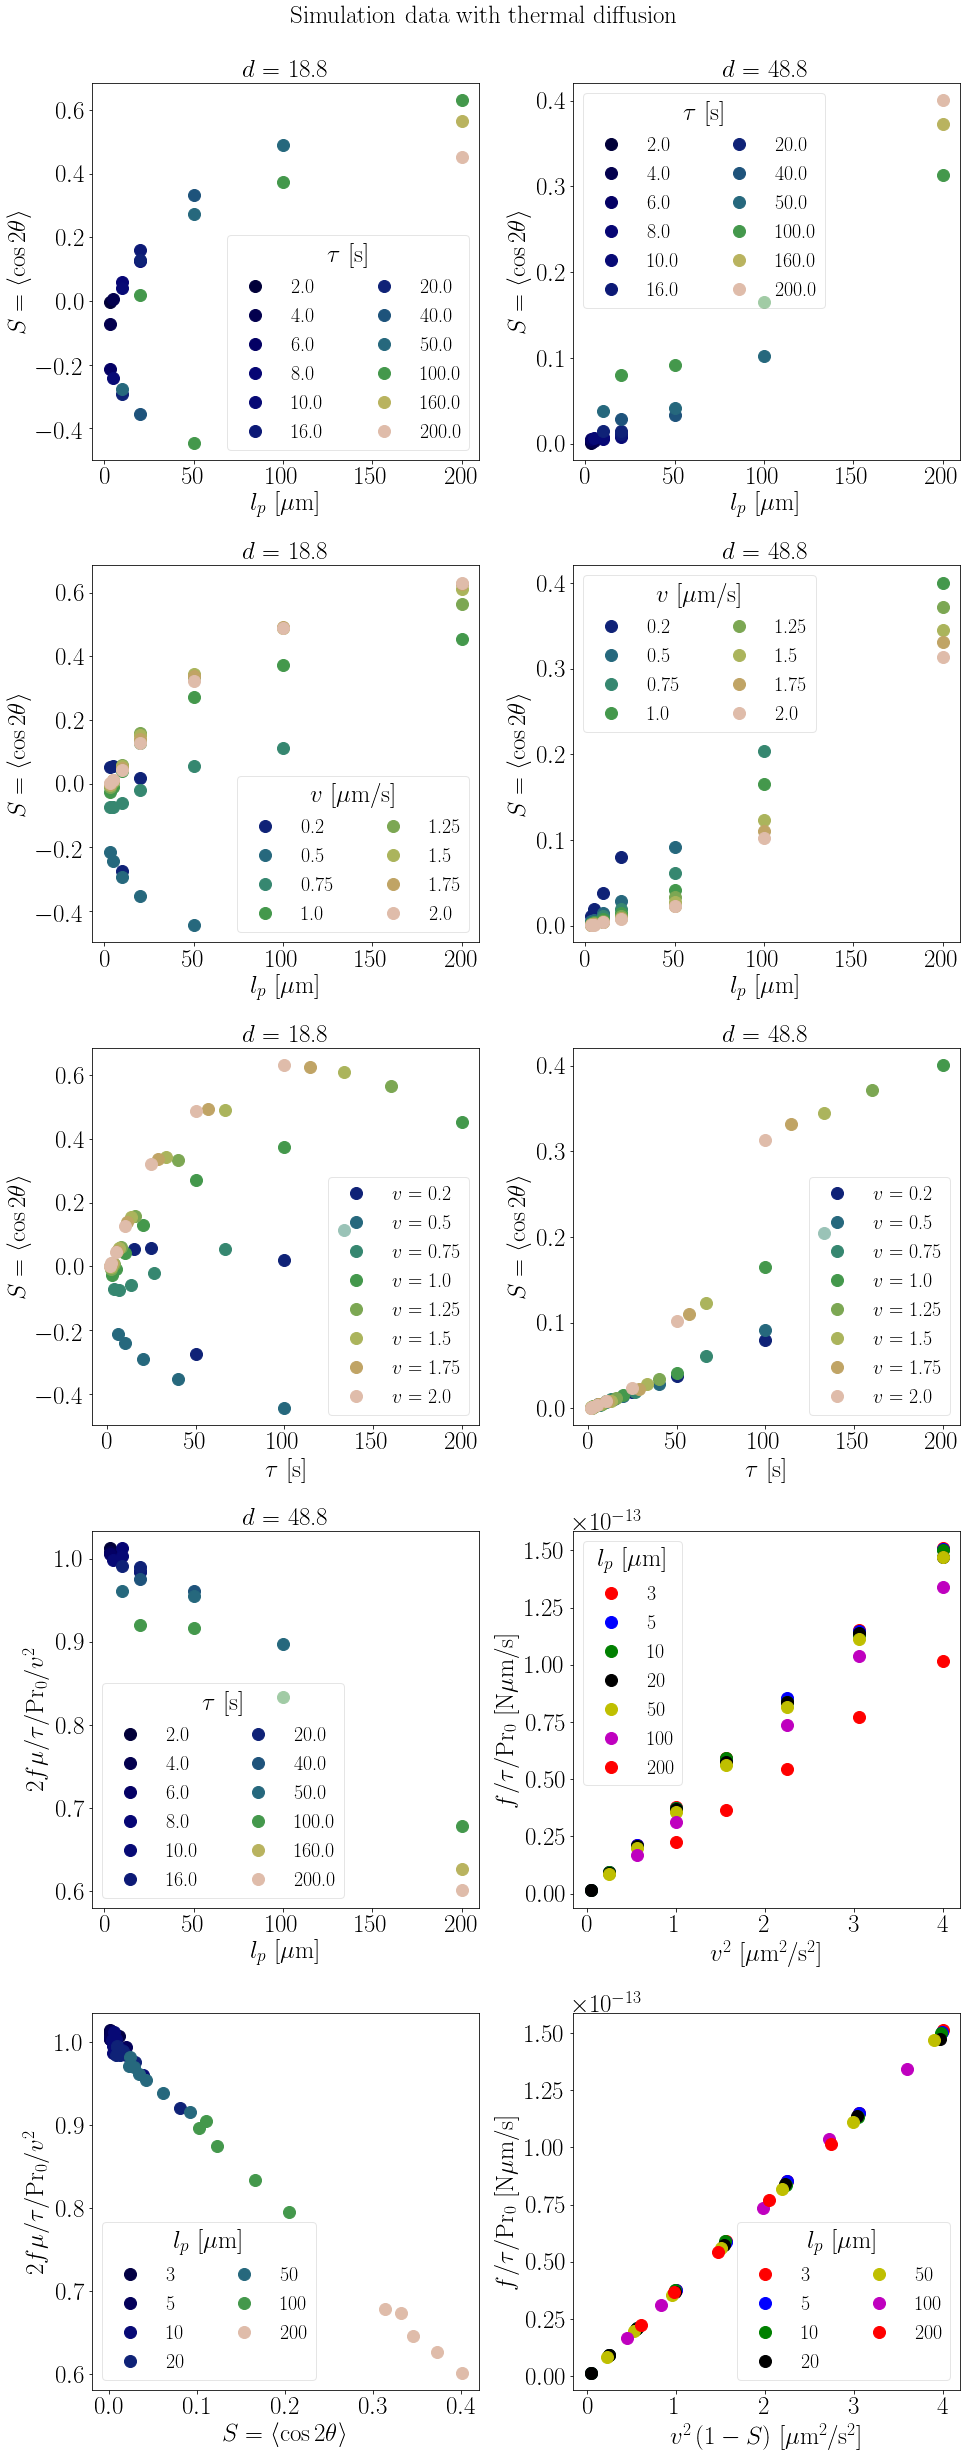

In [134]:
## Plot S vs. v [tau legend] at different distances. 
DistancesToPlot = [18.8, 48.8]
alphaLegend = 0.5
Tau_ToPlot_in_legend = np.sort(pd.unique(OrderParamDF['tau_s'].values))
Tau_ToPlot_in_legend = Tau_ToPlot_in_legend[Tau_ToPlot_in_legend % 2 == 0]
# L_p_ToPlot_in_F_vs_v_squared = pd.unique(OrderParamDF['Persistence_length_um']) # [10, 20, 50, 75, 100, 150, 125, 200, 225]
# L_p_ToPlot_in_F_vs_v_squared = [20, 100, 200, 150, 225, 375]
L_p_ToPlot_in_F_vs_v_squared = [3,5,10,20, 50, 100, 200]
ExportToFile = False
colors = itertools.cycle(["r", "b", "g", 'k', 'y', 'm'])
if 1:     # setting the grpah sizes
    plt.rcParams['font.size']=20
    plt.rcParams["font.family"] = "Times New Roman"
    SMALL_SIZE = 25
    MEDIUM_SIZE = 25
    BIGGER_SIZE = 25
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    mpl.rc('image', cmap='gray')
    mpl.rc('text', usetex=True) # or plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
if 1: 
    from matplotlib import cm
    tau_list = Tau_ToPlot_in_legend
    fig, ax = plt.subplots(5,len(DistancesToPlot), figsize = (14,35))
    # first panel: S(l_p) legend tau
    for axesInd, distance in enumerate(DistancesToPlot):
        # tau_list = tau_list[np.mod(tau_list, 1) == 0]
        for tau in tau_list: 
            color = cm.gist_earth(int(254 * 0.9 * (tau/tau_list.max())))
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['tau_s'] == tau)]
            # label = '$\\tau$ = ' + str(tau)
            label = str(np.round(tau,1))
            ax[0,axesInd].plot(DFforPlot['Persistence_length_um'], DFforPlot['OrderParam'], 'o', 
                               markersize = 12, label = label, color = color)
        ax[0,axesInd].legend(fontsize = 20, framealpha = alphaLegend, ncol= 2, title = r'$\tau$ [s]')
        ax[0,axesInd].set_title('$d$ = ' + str(distance))
        ax[0,axesInd].set_ylabel(r'$S = \left< \cos 2\theta \right>$ ')
        ax[0,axesInd].set_xlabel(r'$l_p$ [$\mu$m]')
    # Second panel: S(l_p) legend velocity
    for axesInd, distance in enumerate(DistancesToPlot):
        velocities = np.sort(pd.unique(OrderParamDF['velocity_umPs']))
        # velocities = velocities[np.mod(velocities, 1) == 0]
        for velocity in velocities:       
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['velocity_umPs'] == velocity)]
            label = '$v$ = ' + str(velocity)
            label = str(velocity)
            color = cm.gist_earth(int(254 * 0.9 * (velocity/velocities.max())))
            ax[1,axesInd].plot(DFforPlot['Persistence_length_um'], DFforPlot['OrderParam'], 'o', 
                               markersize = 12, label = label, color = color)
        ax[1,axesInd].legend(fontsize = 20, framealpha = alphaLegend, ncol= 2, title = r'$v$ [$\mu$m/s]')
        ax[1,axesInd].set_title('$d$ = ' + str(distance))
        ax[1,axesInd].set_ylabel(r'$S = \left< \cos 2\theta \right>$ ')
        ax[1,axesInd].set_xlabel(r'$l_p$ [$\mu$m]')
    # Panel 3: S(tau) legend velocity
    for axesInd, distance in enumerate(DistancesToPlot):
        velocities = np.sort(pd.unique(OrderParamDF['velocity_umPs']))
        # velocities = velocities[np.mod(velocities, 1) == 0]
        for velocity in velocities:        
            DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['velocity_umPs'] == velocity)]
            label = '$v$ = ' + str(velocity)
            color = cm.gist_earth(int(254 * 0.9 * (velocity/velocities.max())))
            ax[2,axesInd].plot(DFforPlot['tau_s'], DFforPlot['OrderParam'], 'o', 
                               markersize = 12, label = label, color = color)
        ax[2,axesInd].legend(fontsize = 20, framealpha = alphaLegend)
        ax[2,axesInd].set_title('$d$ = ' + str(distance))
        ax[2,axesInd].set_ylabel(r'$S = \left< \cos 2\theta \right>$ ')
        ax[2,axesInd].set_xlabel(r'$\tau$ [s]')
    # Panel 4, left: Unitless force/force bulk theory
    for tau in tau_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['tau_s'] == tau)]
        label = str(np.round(tau,1))
        UnitlessForce = 2*DFforPlot['Force_Norm']/(DFforPlot['velocity_umPs']**2)/DFforPlot['drag_N_sPum']
        color = cm.gist_earth(int(254 * 0.9 * 
                                  (tau/tau_list.max()+0)))
        ax[3,0].plot(DFforPlot['Persistence_length_um'], UnitlessForce, 'o', 
                               markersize = 12, label = label, color = color)
    ax[3,0].legend(fontsize = 20, framealpha = alphaLegend, ncol = 2, title=r"$\tau$ [s]")
    ax[3,0].set_title('$d$ = ' + str(distance))
    ax[3,0].set_ylabel(r'$2f\mu/\tau/\mathrm{Pr_0}/v^2 $')
    ax[3,0].set_xlabel(r'$l_p$ [$\mu$m]')
    # Panel 4, right: force theory:
    l_p_list = np.sort(L_p_ToPlot_in_F_vs_v_squared);
    for l in l_p_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['Persistence_length_um'] == l)]
        label = str(l)
        color = next(colors)
        ax[3,1].plot(DFforPlot['velocity_umPs']**2, DFforPlot['Force_Norm'], 'o', 
                               markersize = 12, label = label, color = color)
    ax[3,1].set_ylabel(r'$f/\tau/\mathrm{Pr_0}$ [N$\mu$m/s]')
    ax[3,1].set_xlabel(r'$v^2$ [$\mu$m$^2$/s$^2$]')
    ax[3,1].legend(fontsize = 20, framealpha = alphaLegend, title="$l_p$ [$\mu$m]")
    ax[3,1].plot(OrderParamDF['velocity_umPs']**2, 0.5*OrderParamDF['drag_N_sPum']*OrderParamDF['velocity_umPs']**2, 'k', label = 'Theory')
    # ax[3,1].set_xlim([-0.1,4.2])
    # ax[3,1].set_ylim([-0.5E-14,1.6E-13])
    # panel 5, left, f vs. S: 
    for l in l_p_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == 48.8) & (OrderParamDF['Persistence_length_um'] == l)]
        label = str(np.round(l,1))
        UnitlessForce = 2*DFforPlot['Force_Norm']/(DFforPlot['velocity_umPs']**2)/DFforPlot['drag_N_sPum']
        color = cm.gist_earth(int(254 * 0.9 * (l/l_p_list.max())))
        ax[4,0].plot(DFforPlot['OrderParam'], UnitlessForce, 'o', 
                               markersize = 12, label = label, color = color)
    ax[4,0].set_ylabel(r'$2f\mu/\tau/\mathrm{Pr_0}/v^2$')
    ax[4,0].set_xlabel(r'$S = \left< \cos 2\theta \right>$')
    ax[4,0].legend(fontsize = 20, framealpha = alphaLegend, ncol =2, title="$l_p$ [$\mu$m]")
    # panel 5, right: renormalized f vs. v^2
    l_p_list = np.sort(L_p_ToPlot_in_F_vs_v_squared);
    colors = itertools.cycle(["r", "b", "g", 'k', 'y', 'm'])
    for l in l_p_list:       
        DFforPlot = OrderParamDF.loc[(OrderParamDF['d_um'] == distance) & (OrderParamDF['Persistence_length_um'] == l)]
        label = '$l_p$ = ' + str(l)
        label = str(l)
        # color = cm.hot(int(254 * 0.7 * (l/l_p_list.max())))
        color = next(colors)

        # color = cm.afmhot(int(254 * 0.7 * (l/l_p_list.max())))
        ax[4,1].plot((DFforPlot['velocity_umPs']**2)*(1-DFforPlot['OrderParam']), DFforPlot['Force_Norm'], 'o', 
                               markersize = 12, label = label, color = color)
    ax[4,1].set_ylabel(r'$f/\tau/\mathrm{Pr_0}$ [N$\mu$m/s]')
    ax[4,1].set_xlabel(r'$v^2 \left(1-S\right)$ [$\mu$m$^2$/s$^2$]')
    ax[4,1].legend(fontsize = 20, framealpha = alphaLegend, ncol =2, title="$l_p$ [$\mu$m]")
    # ax[4,1].plot(OrderParamDF['velocity_umPs']**2, 0.5*OrderParamDF['drag_N_sPum']*OrderParamDF['velocity_umPs']**2, 'k', label = 'Theory')
    # general tidying
    fig.tight_layout()
    fig.suptitle('Simulation data with thermal diffusion') 
    fig.subplots_adjust(top=0.95)
    if ExportToFile:
        exportFilename = CurrentFolder + r'\\' + r'OrderParamSummary_withThermalDiffusion.jpg'
        plt.savefig(exportFilename, dpi = 500)

### Other orientational stuff with displacements

In [218]:
BinSize_um = 0.25
# BinEdges = np.linspace(AllDistance.min(), AllDistance.max(), int(AllDistance.max()/BinSize_um))
BinEdges = np.linspace(y.min(), y.max(), int(y.max()/BinSize_um))

AvgXs = np.zeros(len(BinEdges)-1)
AvgYs = np.zeros(len(BinEdges)-1)
AvgVels = np.zeros(len(BinEdges)-1)
AvgThetas = np.zeros(len(BinEdges)-1)
AvgAbsYs, AvgAbsXs = np.zeros(len(BinEdges)-1), np.zeros(len(BinEdges)-1)
p_angles = np.mod(p, 2*np.pi)*180/np.pi
p_angles = - p_angles + 180
for ind in range(len(BinEdges)-1):
    start_um = BinEdges[ind]
    range_um = np.diff(BinEdges).mean()
    AvgYs[ind] = fps* dy[(y>=start_um) & (y<start_um+range_um)].mean()
    AvgThetas[ind] = p_angles[(y>=start_um) & (y<start_um+range_um)].mean()
    

    AvgVels[ind] = fps* (np.sqrt(dy[(y>=start_um) & (y<start_um+range_um)]**2 + 
                          dx[(y>=start_um) & (y<start_um+range_um)]**2)).mean()
    
    AvgVels[ind] = fps* np.sqrt((dy[(y>=start_um) & (y<start_um+range_um)]**2 + 
                          dx[(y>=start_um) & (y<start_um+range_um)]**2).mean())
    
    AvgXs[ind] = fps* dx[(y>=start_um) & (y<start_um+range_um)].mean()
    
    AvgAbsYs[ind] = fps* np.abs(dy[(y>=start_um) & (y<start_um+range_um)]).mean()
    AvgAbsXs[ind] = fps* np.abs(dx[(y>=start_um) & (y<start_um+range_um)]).mean()
    
# AvgAbsYs = AvgVels * np.abs(np.sin(AvgThetas)).mean()
# AvgAbsXs = AvgVels * np.abs(np.cos(AvgThetas)).mean()

C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice.
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice.
  app.launch_new_instance()
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice.
C:\ProgramData\Anaconda3\envs\Python3Trackpy\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: Mean of e

(0, 100)

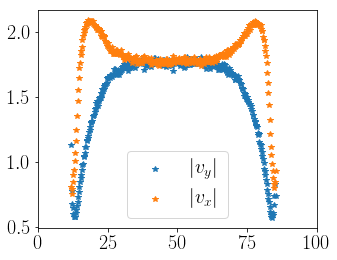

In [28]:
plt.figure(figsize=[5, 4])
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgAbsYs, '*')
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgAbsXs, '*')
plt.legend(['$|v_y|$','$|v_x|$'])
plt.xlim([0, 100])

(-0.1, 0.1)

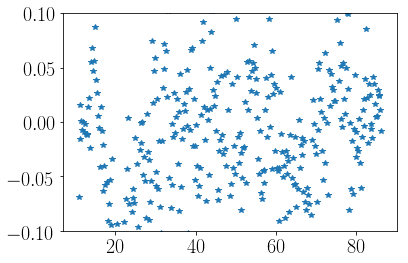

In [210]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgXs, '*')
plt.ylim([-0.1,0.1])

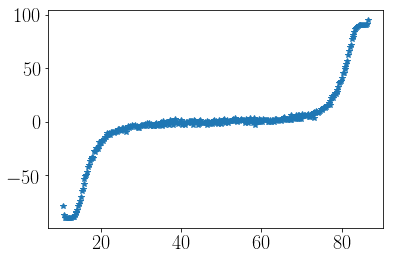

In [211]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgThetas, '*')
# plt.ylim([-0.1,0.1])

(0, 97)

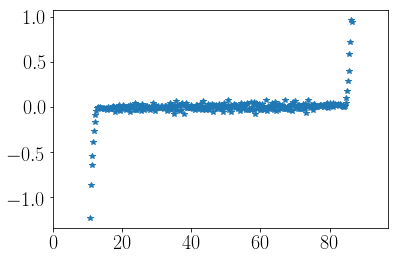

In [212]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgYs, '*')
plt.xlim([0,97])
# plt.ylim([-0.1, 0.1])

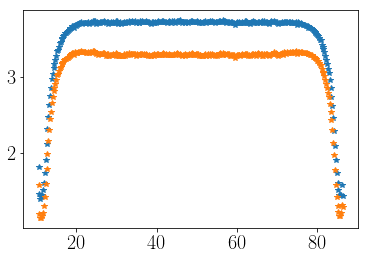

In [214]:
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, AvgVels, '*')
plt.plot(BinEdges[0:-1]+np.diff(BinEdges).mean()/2, np.sqrt(AvgAbsYs**2 + AvgAbsXs**2), '*')

# plt.ylim([-0.1,0.1])

# see Movie

In [175]:
filelistPDF

['C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\\FitDrag_movie\\Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p1_NumPrtcls_100_dragFactorToPsv_1p82_PDfunc.csv']

In [181]:
movieName='Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p1_NumPrtcls_100_dragFactorToPsv_1p82_coords.csv'
subFolder

'20190926_HMDS_AF_tau_SDS_Relay\\FitDrag_movie'

In [182]:
CurrentFolder

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\\FitDrag_movie'

<IPython.core.display.Javascript object>


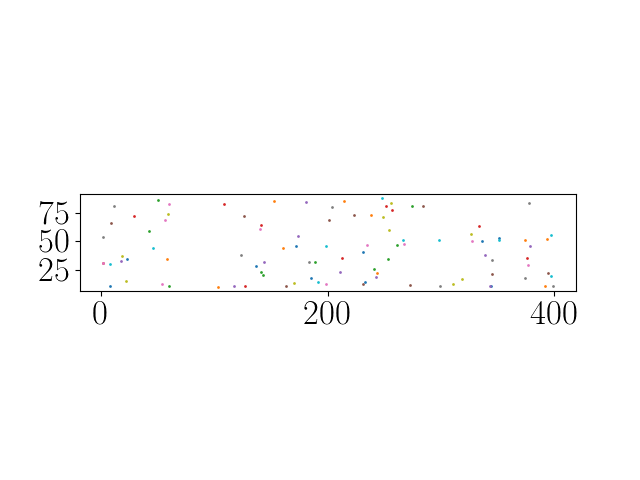

100%|██████████| 100/100 [00:00<00:00, 701.17it/s]


min x: 1.5005371516820112 min y: 9.956137690149955
max x: 399.33279943295037 max y: 88.00855372717555


In [183]:
if 1:
    coords=np.genfromtxt(subFolder+'/'+movieName, delimiter=',')
    # Checking trajectories, last 50 steps
    fig, ax = plt.subplots()
    ParticlesToPlot=range(NumberOfParticles);
    maxy,maxx=0,100
    miny,minx=100,100
    for particleNum in tqdm(ParticlesToPlot):
        x=coords[-1:,3*particleNum+1]
        y=coords[-1:,3*particleNum+2]
        if y.max()>maxy:
            maxy=y.max() ;
        if y.min()<miny:
            miny=y.min() ;
        if x.max()>maxx:
            maxx=x.max() ;
        if x.min()<minx:
            minx=x.min() ;
        ax.plot(x,y,'8',markersize=1)
    # ax1.axis('equal')
    # ax1.set_xlim([0,BoxX])
    # ax1.set_ylim([0,BoxY])
    ax.set_aspect('equal')
    print('min x:', str(minx), 'min y:', str(miny))
    print('max x:', str(maxx), 'max y:', str(maxy))

In [184]:
DirName=CurrentFolder+'/'+movieName[:-29]+'/'
os.mkdir(DirName) # creating new folder
DirName

'C:/Users/M/PycharmProjects/Simulation/20190926_HMDS_AF_tau_SDS_Relay\\FitDrag_movie/Sim_V_8_vel_1p8_Dt_0p1_C_1_Dr_0p1_NumPrtcls_100_dr/'

In [185]:
len(coords)

1250

In [186]:
BoxX_um=200
ChannelLength_um=100
FrameIntervalForMovie=1; 
img=np.zeros([ChannelLength_um,BoxX_um])
MovieCoords=coords[::FrameIntervalForMovie,:]

In [187]:
def MakeFrameIndexForAnimation(FrameNum,MaximalFrameNum):
    IndexRequiredLength=len(str(MaximalFrameNum));
    LengthOfCurrentString=len(str(FrameNum))
    NumberOfZerosToAdd=IndexRequiredLength-LengthOfCurrentString;
    NewIndexForCurrentFrame='0'*NumberOfZerosToAdd+str(FrameNum)
    return NewIndexForCurrentFrame 
def format_func(value, tick_number):
    return str(int(value))

In [191]:
for i in tqdm(range(len(MovieCoords))):  # this list is using the cropped enumeration, starting at 0 for the cropped. 
    plt.ioff()
    fig, ax = plt.subplots()
    NewIndexForCurrentFrame=MakeFrameIndexForAnimation(i,len(MovieCoords)) # just an index to save the file on HD
    ax.scatter(MovieCoords[i,1::3], MovieCoords[i,2::3], marker ='.', s=2, color='k')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    pathname=DirName+movieName[:-11]+'_'+NewIndexForCurrentFrame+'.png'
    ax.set_xlim([0,BoxX_um])
    ax.set_ylim([0,ChannelLength_um])
    fig.savefig(pathname, dpi=200)
    # fig.clf()
    plt.close(fig)

100%|██████████| 1250/1250 [03:02<00:00,  6.85it/s]


In [192]:
# To create a movie from the jpeg's
fps=10; 
temp=DirName
DirName=temp
DirNameForImageio=temp
filenamesForImageio = [f for f in os.listdir(DirName) if f.endswith('.png')]
import imageio
# DirNameForImageio='C:/Users/M/Dropbox/MicroOsmotic/Python/'+DirName
MovieFileNameImageIO=('/'+movieName[:-4]+'.mp4')
DirNameForImageio=DirName
with imageio.get_writer(DirNameForImageio+'\\'+MovieFileNameImageIO, mode='I', fps=fps) as writer:
    for ImagIOfilename in tqdm(filenamesForImageio):
        image = imageio.imread(DirNameForImageio+'\\'+ImagIOfilename)
        writer.append_data(image)
writer.close()

100%|██████████| 1250/1250 [00:32<00:00, 38.40it/s]
